# Phylodynamics of dengue in Singapore

First we import the relevant modules:

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import shutil
import os
from datetime import datetime, timedelta
import subprocess
import xml.etree.ElementTree as ET
import xml.dom.minidom
from lxml import etree
import os

## Input data filtering criteria

### Existing project
If you are working with an existing project (for example, you have already generated the required files, and want to use these in other analyses, such as tfpscanner), then you specify, as the value for `existing_project`, the name of the folder from which you want to work from. Otherwise, set this variable equal to None.

### Project filters
You can specify what subset of the data you want to perform the phylogenetic analyses. The filter options are based on the column entries of the metadata file. The features that are appropriate for such filtering include:
- Receipt date (Diagnostics) **(entered as a tuple range, from first to last date)**
- Serotype
- Genotype
- Clade

### BEAST
If performing BEAST analysis, you need to select which version you require. 

In this implementation, all analyses bar **Skygrid** require BEAST2.

#### Priors
The following priors are available:
- Coalescent Exponential Population (`exponential`)
- Coalescent Bayesian Skyline (`skyline`)
- Coalescent Extended Bayesian Skyline (`extended_skyline`) (not yet working)
- Coalescent Bayesian SkyGrid (`skygrid`)
- Timtam (`timtam`)

One can select the prior by setting `prior` equal to the prior name of choice in the bracketed terms above.


#### MCMC
MCMC in BEAST requires three inputs:
- Chain length (`chainLength`)
- Number of chains (`no_chains`)
- How often to sample (`sample_every`)

### tfpscanner
*Note: The implementation of this analysis is currently unfit for our analysis due to the low amount of sequencing data. However, the script still exist, and we may explore this in the future.*

You can perform tfpscanner immediately after generating the tree files by setting `tfptree` = **True**. Otherwise, set it to **False**.

If **True**, specify the month interval you require. Given the range of dates, this will generate the first tree from the start date to the date `month_interval` months in the future. The second tree will span from the *same start date* to `month_interval` x 2 months in the future, and so until the end date is reached.

In [3]:
existing_project = None # e.g. data_20240416-135805

project_filters = {
    "Receipt date (Diagnostics)": ('2017-01-01', '2020-01-01'),
	"Serotype": "DEN-3"
	# "Genotype: __"
    # "Clade: __"
}

beast = True
beast_version = 'beast2' # beast1 or beast2 

prior = 'timtam'

# MCMC
chainLength = 1000000
no_chains = 4
sample_every = 1000

# tfpscanner
tfptree = False
month_interval = 3

## ---------------

# Select the previous year to use as a reference for analysis
# Change to another previous year if required
lower_bound_year = datetime.strptime(project_filters["Receipt date (Diagnostics)"][0], "%Y-%m-%d")
upper_bound_year = datetime.strptime(project_filters["Receipt date (Diagnostics)"][-1], "%Y-%m-%d")
analysis_reference_year = lower_bound_year.replace(year=lower_bound_year.year - 1).year

prior_xml_dict = {'exponential': 'beast_templates/coalescent_exponential.xml',
                  'skyline': 'beast_templates/bayesian_skyline.xml',
                  'extended_skyline': 'beast_templates/extended_bayesian_skyline.xml',
                  'skygrid': 'beast_templates/bayesian_skygrid.xml',
                  'timtam': 'beast_templates/timtam.xml'}

## Data processing functions

In [4]:
def filter_dataframe(df, filters):
    """
    Filters a DataFrame based on specified criteria for each column.

    Parameters:
    - df: pandas.DataFrame to filter
    - filters: dict where keys are column names and values are the required entries
               (either a single value or a list of values)

    Returns:
    - A filtered pandas.DataFrame
    """
    
    filtered_df = df.copy()
    for column, criteria in filters.items():
        if criteria is not None:
            if isinstance(criteria, list):
                # If the criteria is a list, filter to include any of the values in the list
                filtered_df = filtered_df[filtered_df[column].isin(criteria)]
            elif isinstance(criteria, tuple) and len(criteria) == 2:
                # If the criteria is a tuple and has two elements, interpret as a date range
                filtered_df = filtered_df[(filtered_df[column] >= criteria[0]) & (filtered_df[column] <= criteria[1])]
            else:
                # If the criteria is a single value, filter based on that value
                filtered_df = filtered_df[filtered_df[column] == criteria]
    return filtered_df


def create_sample_dates_file(csv_file_path, output_folder, output_file_name):
    """
    Creates a file with Sample ID and Tip.Dates from a CSV, tab-separated.

    Parameters:
    - csv_file_path: Path to the input CSV file.
    - output_folder: Folder where the output file will be saved.
    - output_file_name: Name of the output file.
    """
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the DataFrame from CSV
    df = pd.read_csv(csv_file_path)

    # Extract 'Sample ID' and 'Tip.Dates' columns
    sample_dates_df = df[['Sample ID', 'Tip.Dates']]

    # Specify the file path for the output file
    output_file_path = os.path.join(output_folder, output_file_name)

    # Write the data to the file, tab-separated, without index and header
    sample_dates_df.to_csv(output_file_path, sep='\t', index=False, header=False)
    

def create_districts_file(csv_file_path, output_folder, output_file_name):
    """
    Reads a CSV file, extracts Sample ID and District, and saves to a new text file.
    Adds custom column names 'traits' and 'districts'.

    Parameters:
    - csv_file_path: Full path to the input CSV file.
    - output_folder: Folder where the output file will be saved.
    - output_file_name: Name for the output text file.
    """
    # Load the DataFrame from the specified CSV file
    df = pd.read_csv(csv_file_path)

    # Select and rename the required columns
    districts_df = df[['Sample ID', 'District']].rename(columns={'Sample ID': 'traits', 
                                                                 'District': 'districts'})

    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Construct the full path for the output file
    output_path = os.path.join(output_folder, output_file_name)

    # Save the DataFrame to a text file, tab-separated, including the header
    districts_df.to_csv(output_path, sep='\t', index=False, header=True)


# Function to check if 'history' is in any text
def contains_history(text):
    return 'history' in text.lower()

def remove_history_tags(xml_file):
    # Parse the XML file
    parser = etree.XMLParser(remove_blank_text=True)
    tree = etree.parse(xml_file, parser)
    root = tree.getroot()

    # Create a list to hold elements to remove
    elements_to_remove = []

    # Traverse all elements in the tree
    for elem in root.iter():
        # Check element's tag and attributes for 'history'
        if contains_history(elem.tag) or any(contains_history(attr) for attr in elem.attrib.values()):
            elements_to_remove.append(elem)
        # Check all children as well
        for child in elem:
            if contains_history(child.tag) or any(contains_history(attr) for attr in child.attrib.values()):
                elements_to_remove.append(child)

    # Remove identified elements
    for elem in elements_to_remove:
        parent = elem.getparent()
        if parent is not None:
            parent.remove(elem)

    # Save the modified tree back to a file or return as a string
    tree.write('modified_beast_template.xml', pretty_print=True)  # or return etree.tostring(root, pretty_print=True)


def tree_generation(samples_df, tree_sizes, first_date, last_date):
    """
    Generates phylogenetic trees for tfpscanner from a set of sample sequences and a 
    reference sequence. Assumes `samples_df` contains 'Sample ID' and sequences are stored 
    in specified FASTA files.
    
    Parameters:
    - samples_df: DataFrame containing sample identifiers.
    - first_date, last_date: Date range for naming the output file.
    """
    
    temp_folder = "projects/temp"
    os.makedirs(temp_folder, exist_ok=True)
    
    # -----------------
    # Samples .fasta
    # -----------------
    # Filter sequences from combined FASTA and write to new file in the temp folder.
    sample_ids = samples_df['Sample ID'].tolist()[1:]
    combined_fasta_path = "data/D1-4_NDA_SM_NUS.fasta"
    filtered_fasta_path = os.path.join(temp_folder, "project_samples.fasta")
    
    records_to_write = [record for record in SeqIO.parse(combined_fasta_path, "fasta") if record.id in sample_ids]
    SeqIO.write(records_to_write, filtered_fasta_path, "fasta")
    
    # -------------------
    # Reference fasta
    # -------------------
    # Find and write the reference sequence to a new FASTA in the temp folder.
    reference_id = samples_df['Sample ID'].iloc[0]
    all_reference_fasta_path = 'data/references/references.fasta'
    
    for record in SeqIO.parse(all_reference_fasta_path, 'fasta'):
        if record.id == reference_id:
            reference_fasta_path = os.path.join(temp_folder, f'reference_{analysis_reference_year}.fasta')
            SeqIO.write(record, reference_fasta_path, 'fasta')
            break
    
    # ---------------------------
    # MAPLE
    # ---------------------------
    # Run a Bash script for analysis, assuming it handles errors internally.
    subprocess.run(['bash', "./MAPLE_Tree.sh", "project_samples.fasta", f'reference_{analysis_reference_year}.fasta', temp_folder], capture_output=True, text=True)
    
    # ---------------------------
    # Phylo tree
    # ---------------------------
    # Find the MAPLE output and move it to a more permanent location.
    temp_folder_MAPLE = next((dirpath for dirpath, dirnames, filenames in os.walk(temp_folder) if dirpath.endswith("project_samples.MAPLE")), None)
    
    if not temp_folder_MAPLE:
        print("The specified folder was not found.")
    else:
        source_file = os.path.join(temp_folder_MAPLE, "project_samples.MAPLE_output_tree.tree")
        trees_folder = "projects/MAPLE_trees"
        os.makedirs(trees_folder, exist_ok=True)
        
        new_file_path = os.path.join(trees_folder, f"{first_date}-to-{last_date}.tree")
        shutil.copy2(source_file, new_file_path)
        
        # Cleanup: remove the temp folder and its contents.
        try:
            shutil.rmtree(temp_folder)
        except Exception as e:
            print(f"Failed to delete {temp_folder}. Reason: {e}")

    tree_sizes[f"{first_date}-to-{last_date}"] = samples_df.shape[0]
    
    return trees_folder, tree_sizes


def file_generation(samples_df, project_dir, find_reference = True, 
                    beast_analysis = False, tfp_trees = False):

    ### -----------------
    ### Samples .fasta
    ### -----------------

    # Assuming `samples_df` is your DataFrame and contains the `Sample ID` column
    sample_ids = samples_df['Sample ID'].tolist()

    # Path to your combined FASTA file
    combined_fasta_path = "data/D1-4_NDA_SM_NUS.fasta"

    # Assuming outfile is your FASTA file name
    filtered_fasta_path = os.path.join(project_dir, "project_samples.fasta")

    # Filter and write the sequences to the new FASTA file
    with open(filtered_fasta_path, 'w') as outfile:
        for record in SeqIO.parse(combined_fasta_path, "fasta"):
            # Check if the record.id is in your list of Sample IDs
            if record.id in sample_ids:
                SeqIO.write(record, outfile, "fasta")
                

    ### ----------------------------------------------
    ### Find reference sequence and add to metadata
    ### ----------------------------------------------

    if find_reference:
        # Find the most common value (mode) in the 'Serotype' column
        most_common_serotype = samples_df['Serotype'].mode()[0]
    else:
        # Set the path to the CSV file
        metadata_main_project = f"{project_folder}/dengue_samples.metadata.csv"

        # Read the CSV file into a DataFrame
        temp_data = pd.read_csv(metadata_main_project)

        # Find the most common serotype
        most_common_serotype = temp_data['Serotype'].mode()[0]


    references_metadata = pd.read_csv('data/references/references.csv')

    # Find the row in references_metadata that matches the conditions
    matching_row = references_metadata[
        (references_metadata['Year'] == analysis_reference_year) & 
        (references_metadata['Serotype'] == most_common_serotype)
    ]

    # Since there might be multiple rows matching the condition, we'll take the first match
    # If you expect only one match or want the first match, use .iloc[0:1] to get it as a DataFrame
    reference_row = matching_row.iloc[0:1]

    # Concatenate the matching row with filtered_sample_df, making sure the matching row is first
    # Reset the index to account for the new row order and drop the old index
    samples_df = pd.concat([reference_row, samples_df], ignore_index=True)

    # Specify the file path including the folder name
    metadata_path = os.path.join(project_dir, "dengue_samples.metadata.csv")

    # Assuming filtered_sample_df is your filtered DataFrame
    samples_df.to_csv(metadata_path, index=False)

        

    ### ----------------------------------------------
    ### DESCRIPTION.MD
    ### sample info and statistics of current analysis
    ### ----------------------------------------------
        
    # Step 1: Extract 'Sample ID' and 'Serotype' from the first row
    first_row = samples_df.iloc[0]
    sample_id = first_row['Sample ID']
    serotype = first_row['Serotype']

    # Step 2: Format the reference string
    reference_entry = f"\n**Reference:** {sample_id} ({serotype})\n"
        
    # Create a pivot table with 'Serotype' as rows, 'Year' as columns, and count the occurrences
    pivot_table = pd.pivot_table(samples_df, index='Serotype', columns='Year', aggfunc='size', fill_value=0)

    # Step 1: Calculate 'Total Serotype Cases'
    pivot_table['Total Serotype Cases'] = pivot_table.sum(axis=1)

    # Step 2: Calculate 'Total Serotype Cases (%)'
    total_cases = pivot_table['Total Serotype Cases'].sum()
    pivot_table['Total Serotype Cases (%)'] = pivot_table['Total Serotype Cases'] / total_cases * 100

    # Convert the updated pivot table to a markdown format string
    markdown_table = pivot_table.to_markdown()

    # Count the number of data rows excluding the first
    num_sequences = len(samples_df)
    # The text you want to write to the file
    text_to_write = f"\n**Number of sequences:** {num_sequences}\n"

    # Save the README file with the filters description
    readme_path = os.path.join(project_dir, "DESCRIPTION.md")
    with open(readme_path, 'w') as readme_file:
        readme_file.write("# Data Filters Applied\n\n")
        readme_file.write("This folder contains data filtered with the following criteria:\n")
        for key, value in project_filters.items():
            readme_file.write(f"- **{key}**: {value}\n")
        readme_file.write(text_to_write)
        readme_file.write("\n## Serotype Distributions\n\n" + markdown_table + "\n")
        readme_file.write(reference_entry)


    ### -------------------
    ### Reference fasta
    ### -------------------

    # Extract the reference ID from the first entry of the matching row
    reference_id = samples_df['Sample ID'].iloc[0]

    # Specify the path to the combined references FASTA file
    all_reference_fasta_path = 'data/references/references.fasta'

    # Prepare to search for and store the matching sequence
    matching_sequence = None

    # Read the FASTA file and find the sequence that matches the reference ID
    with open(all_reference_fasta_path, 'r') as fasta:
        for record in SeqIO.parse(fasta, 'fasta'):
            if record.id == reference_id:
                matching_sequence = record
                break  # Stop searching once the match is found

    # Define the path for saving the specific reference sequence
    reference_fasta_path = os.path.join(project_dir, f'reference_{analysis_reference_year}_{most_common_serotype}.fasta')

    # Write the found sequence to a new FASTA file in the project directory
    with open(reference_fasta_path, 'w') as output_file:
        SeqIO.write(matching_sequence, output_file, 'fasta')


    ## ---------------------------
    ## MAPLE
    ## ---------------------------
        
    # Run the Bash script to generate the MAPLE files
    subprocess.run(['bash', "./MAPLE_Tree.sh", "project_samples.fasta", 
                        f'reference_{analysis_reference_year}_{most_common_serotype}.fasta', 
                        project_dir], capture_output=True, text=True)

    print(f"MAPLE files generated")


    ## ---------------------------
    ## BEAUTI
    ## ---------------------------
        
    # Set up BEAUti analysis directory
    os.makedirs(f"{project_dir}/beauti", exist_ok=True)

    # Generate sample dates and districts files for BEAUti
    create_sample_dates_file(metadata_path, f"{project_dir}/beauti", "sampleDates.txt")
    create_districts_file(metadata_path, f"{project_dir}/beauti", "districts.txt")

    # Prepare paths for copying and renaming the aligned sequence file for BEAUti
    maple_fasta_source_path = f"{project_dir}/project_samples.MAPLE/project_samples.aligned.fasta"
    beauti_destination_path = f"{project_dir}/beauti/input_sequences.fasta"

    # Ensure the destination directory exists
    os.makedirs(os.path.dirname(beauti_destination_path), exist_ok=True)

    # Copy and rename the aligned sequence file for BEAUti analysis
    shutil.copy(maple_fasta_source_path, beauti_destination_path)

    # Confirm generation of BEAUti files
    print("BEAUti files generated")


    ### --------------------------------
    ### BEAST xml 
    ### --------------------------------

    if tfp_trees:
        print('BEAST analysis for entire dataset')

    if beast_analysis: 
        update_beast_template_with_fasta_and_dates(f"{project_dir}/beauti/input_sequences.fasta", 
                                                prior_xml_dict[prior], 
                                                f"{project_dir}/beauti/sampleDates.txt", 
                                                project_dir,
                                                chain_length = chainLength, 
                                                chains = no_chains, 
                                                resample_every = sample_every)

    ### --------------------------------
    ### tfpscanner 
    ### --------------------------------

    if tfp_trees:
        print('Creating subset trees for tfpscanner')

        # Ensure the base directory for tfpscanner exists
        os.makedirs(f"{project_dir}/tfpscanner", exist_ok=True)

        # Extract start and end years from project filters and define the date range

        start_date = datetime(lower_bound_year.year, 1, 1)
        end_date = datetime(lower_bound_year.year, 12, 31)

        

        # Prepare the 'Receipt date (Diagnostics)' column for date comparisons
        samples_df['Receipt date (Diagnostics)'] = pd.to_datetime(samples_df['Receipt date (Diagnostics)']).dt.date

        current_date = start_date
        formatted_start_date = start_date.strftime('%Y-%m-%d')
        formatted_current_date = start_date.strftime('%Y-%m-%d')

        tree_sizes = {}

        while current_date < end_date:
            print("Generating tfpscanner tree")
            
            # Calculate the last day of the current month based on the defined month interval
            next_month = current_date + pd.DateOffset(months=month_interval)
            last_day_of_month = (next_month - timedelta(days=1)).date()
            print(f"From {formatted_start_date} to {last_day_of_month}")

            # Filter the DataFrame to the current month
            mask = (samples_df['Receipt date (Diagnostics)'] <= last_day_of_month)
            filtered_samples_df = samples_df.loc[mask]

            # Generate trees and update tree sizes
            trees_folder, tree_sizes = tree_generation(filtered_samples_df, tree_sizes, 
                                                    formatted_start_date,
                                                    str(last_day_of_month))
            

            # Create a temporary folder for BEAST files
            temp_folder = "temp"
            os.makedirs(temp_folder, exist_ok=True)

            # Generate BEAUTi files skipping the first sample, without TFP trees
            file_generation(filtered_samples_df[1:], temp_folder, find_reference=False,
                            beast_analysis=True, tfp_trees=False)

            # Set up paths for moving the BEAST output
            source_path = os.path.join(temp_folder, "beast/modified_beast_template-input_sequences.trees")
            destination_path = os.path.join(project_dir, "tfpscanner/beast_trees",
                                            f"BEAST_{formatted_start_date}-to-{last_day_of_month}.trees")

            # Ensure the destination directory exists
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)

            # Move the .trees file to its new location
            shutil.copy(source_path, destination_path)

            # Clean up the temporary folder
            shutil.rmtree(temp_folder)

            # Prepare for the next iteration
            current_date = next_month
            formatted_current_date = current_date.strftime('%Y-%m-%d')  # Update the formatted start date for the new period


        shutil.move(trees_folder, f"{project_dir}/tfpscanner")

        # Specify the base project folder and subdirectories
        beast_trees_folder = f"{project_dir}/tfpscanner/beast_trees"

        # Directories for the organized files
        trees_files_dir = os.path.join(beast_trees_folder, 'trees_files')
        summary_trees_dir = os.path.join(beast_trees_folder, 'summary_trees')

        # Create directories if they don't exist
        os.makedirs(trees_files_dir, exist_ok=True)
        os.makedirs(summary_trees_dir, exist_ok=True)

        # Walk through the directory containing the .trees files
        for filename in os.listdir(beast_trees_folder):
            if filename.endswith('.trees'):
                full_path = os.path.join(beast_trees_folder, filename)
                new_filename = filename.replace('.trees', '.tree')
                output_path = os.path.join(beast_trees_folder, new_filename)

                # Construct the treeannotator command
                command = ['/Users/conor/tools/BEAST_2.7.5/bin/treeannotator', 
                           full_path, output_path]

                # Run the command
                try:
                    subprocess.run(command, check=True)
                    print(f"Processed {filename} successfully.")
                    
                    # Move the original .trees file and the new .tree file to their respective directories
                    shutil.move(full_path, os.path.join(trees_files_dir, filename))
                    shutil.move(output_path, os.path.join(summary_trees_dir, new_filename))
                except subprocess.CalledProcessError as e:
                    print(f"Failed to process {filename}: {e}")


        readme_path = os.path.join(project_dir, "DESCRIPTION.md")
        with open(readme_path, 'a') as readme_file:
            readme_file.write("\n# tfpscanner trees\n\n")
            readme_file.write(f"No. trees generated: {len(tree_sizes)}\n\n")
            readme_file.write("## Samples per tree\n\n")

            # Creating markdown table
            readme_file.write("| Tree Name | Number of Samples |\n")
            readme_file.write("|-----------|-------------------|\n")
            for tree_name, sample_count in tree_sizes.items():
                readme_file.write(f"| {tree_name} | {sample_count} |\n")
        
        # Prepare the DataFrame for tfpscanner analysis by selecting and renaming columns
        tfpscanner_traits = samples_df[['Sample ID', 'Receipt date (Diagnostics)', 'District', 'Serotype', 'Tip.Dates']].copy()
        tfpscanner_traits.columns = ['sequence_name', 'sample_date', 'region', 'lineage', 'sample_time']

        # Construct the path for the traits CSV and save the DataFrame there
        tfpscanner_path = os.path.join(f"{project_dir}/tfpscanner", 'tfpscanner_traits.csv')
        tfpscanner_traits.to_csv(tfpscanner_path, index=False)

        # Build and execute the command to run tfpscanner with Rscript
        tfpscan_command = f"Rscript tfpscanner.R {project_dir}/tfpscanner"
        os.system(tfpscan_command)

    return(samples_df)


def update_beast_template_with_fasta_and_dates(fasta_file, template_file, dates_file, 
                                               project_directory, chain_length, 
                                               chains, resample_every):
    
    # Ensure the project directory exists
    output_directory = os.path.join(project_directory, "beast")
    os.makedirs(output_directory, exist_ok=True)
    
    # Define the path for the output XML file within the new directory
    output_xml_file = os.path.join(output_directory, "modified_beast_template.xml")

    if beast_version == 'beast2': 
        # Step 1: Read and parse the dates file
        sequence_dates = {}
        with open(dates_file, 'r') as f:
            for line in f:
                parts = line.strip().split()  # Assuming the file is tab or space delimited
                if len(parts) >= 2:
                    sequence_dates[parts[0]] = parts[1]
        
        # Construct the value string for the <trait> element
        date_values = ','.join([f'{seq}={date}' for seq, date in sequence_dates.items()])

        # Parse the FASTA file and create sequence elements
        new_sequences = []
        with open(fasta_file, 'r') as f:
            sequence_id = ''
            sequence_value = ''
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if sequence_id and sequence_value:
                        sequence = ET.Element('sequence')
                        sequence.set('id', 'seq_' + sequence_id)
                        sequence.set('spec', 'Sequence')
                        sequence.set('taxon', sequence_id)
                        sequence.set('totalcount', "4")
                        sequence.set('value', sequence_value.lower())
                        new_sequences.append(sequence)
                    
                    sequence_id = line[1:]
                    sequence_value = ''
                else:
                    sequence_value += line

            if sequence_id and sequence_value:
                sequence = ET.Element('sequence')
                sequence.set('id', 'seq_' + sequence_id)
                sequence.set('spec', 'Sequence')
                sequence.set('taxon', sequence_id)
                sequence.set('totalcount', "4")
                sequence.set('value', sequence_value.lower())
                new_sequences.append(sequence)

        # Parse the BEAST template file
        tree = ET.parse(template_file)
        root = tree.getroot()

        # Find and clear the <data> element, then repopulate it
        data_element = root.find('.//data')
        if data_element is not None:
            data_element.clear()
            data_element.set('id', 'input_sequences')
            data_element.set('spec', 'Alignment')
            data_element.set('name', 'alignment')
            for seq in new_sequences:
                data_element.append(seq)
        else:
            print("No <data> element found in the template. Adjust the script as needed.")
            return

        # Update the <run> element attributes based on provided values
        run_element = root.find('.//run[@id="mcmcmc"]')
        if run_element is not None:
            run_element.set('chainLength', str(chain_length))
            run_element.set('chains', str(chains))
            run_element.set('resampleEvery', str(resample_every))
        else:
            print("No <run> element with id='mcmcmc' found in the template. Please check your template.")

        # Update the <trait> element's value attribute with dates
        trait_element = root.find('.//trait[@id="dateTrait.t:input_sequences"]')
        if trait_element is not None:
            trait_element.set('value', date_values)
        else:
            print("No <trait> element with the specified id found. Please check your template.")

        # Convert the entire tree to a string and insert newlines for readability
        xml_string = ET.tostring(root, encoding='unicode')
        formatted_xml_string = xml_string.replace('>', '>\n')

        # Write the formatted string to the output file
        with open(output_xml_file, 'w', encoding='UTF-8') as f:
            f.write(formatted_xml_string)

        # Usage
        if prior == 'timtam':
            # Build and execute the command to run tfpscanner with Rscript
            # Create the directory
            os.makedirs(f"{project_directory}/timtam", exist_ok=True)
            timtam_command = f"Rscript timtam/setup-data-with-times.R {project_directory}"
            os.system(timtam_command)

        original_directory = os.getcwd()
        os.chdir(os.path.join(project_directory, "beast"))

        # Command to run beast2
        command = ['/Users/conor/tools/BEAST_2.7.5/bin/beast',
                '-overwrite', 
                    "modified_beast_template.xml"]
        
        try:
            result = subprocess.run(command, check=True, stdout=subprocess.PIPE, 
                                    stderr=subprocess.PIPE, text=True)
            print("BEAST ran successfully.")
            print("Output:\n", result.stdout)
        except subprocess.CalledProcessError as e:
            print("Error running BEAST:")
            print(e.stderr)
        finally:
            # Change back to the original directory
            os.chdir(original_directory)
    
    else:
        # Step 1: Read the sampleDates.txt and create a dictionary of taxon IDs and dates
        dates_dict = {}
        with open(dates_file, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) >= 2:
                    taxon_id, date_value = parts[0], parts[1]
                    dates_dict[taxon_id] = date_value

        # Step 2: Read the FASTA file and create a dictionary of taxon IDs and their sequences
        sequence_dict = {}
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequence_dict[record.id] = str(record.seq).upper()

        # Step 3: Modify the XML file
        tree = ET.parse(template_file)
        root = tree.getroot()

        # Update the <taxa> section
        taxa = root.find('.//taxa')
        if taxa is None:
            taxa = ET.SubElement(root, 'taxa')
        else:
            taxa.clear()  # Clear existing entries if needed
            taxa.attrib = {'id': 'taxa'}  # Ensure the correct attributes are set

        for taxon_id, date_value in dates_dict.items():
            taxon_element = ET.SubElement(taxa, 'taxon', {'id': taxon_id})
            date_element = ET.SubElement(taxon_element, 'date', {
                'value': date_value,
                'direction': 'forwards',
                'units': 'years'
            })

        # Update the <alignment> section
        alignment = root.find('.//alignment')
        if alignment is None:
            alignment = ET.SubElement(root, 'alignment', {'id': 'alignment', 'dataType': 'nucleotide'})
        else:
            alignment.clear()  # Clear existing entries if needed
            alignment.attrib = {'id': 'alignment', 'dataType': 'nucleotide'}  # Ensure the correct attributes are set

        for taxon_id, sequence in sequence_dict.items():
            sequence_element = ET.SubElement(alignment, 'sequence')
            taxon_element = ET.SubElement(sequence_element, 'taxon', {'idref': taxon_id})  # Add taxon reference first
            taxon_element.tail = sequence  # Then set sequence text

        # Step 4: Write the updated XML back to the new file
        tree.write(f'{output_directory}/modified_beast_template.xml', encoding='utf-8', xml_declaration=True)

        # Convert to a pretty-printed XML string and write to the file
        xmlstr = xml.dom.minidom.parseString(ET.tostring(root)).toprettyxml(indent="    ")
        with open(f'{output_directory}/modified_beast_template.xml', 'w') as f:
            f.write(xmlstr)

        original_directory = os.getcwd()
        os.chdir(os.path.join(project_directory, "beast"))
        beast_directory = os.getcwd()

        # Command to run beast2
        #command = ['beast',
        #        '-overwrite', 
        #        "../modified_beast_template.xml"]
        
        # Define the command and the XML file path
        command = "beast -overwrite ../modified_beast_template.xml"

        # Prepare a file with commands
        commands_file = 'run_commands.sh'
        with open(commands_file, 'w') as file:
            for i in range(1, no_chains + 1):
                chain_directory = os.path.join(os.getcwd(), f'beast_chain_{i}')
                os.makedirs(chain_directory, exist_ok=True)
                # Write command to file, prepending 'cd' to change directory
                file.write(f"cd {chain_directory} && {command}\n")

        # Now use GNU Parallel to run the commands in the file in parallel
        parallel_command = f"parallel --bar < {commands_file}"
        try:
            # Execute GNU Parallel
            result = subprocess.run(parallel_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            print("Parallel execution complete. Output:\n", result.stdout)
        except subprocess.CalledProcessError as e:
            print("Error during parallel execution:\n", e.stderr)
        
        # for i in range(1, no_chains + 1):
        #     # Create a new directory for each chain
        #     chain_directory = os.path.join(os.getcwd(), f'beast_chain_{i}')
        #     os.makedirs(chain_directory, exist_ok=True)
            
        #     # Change to the new directory to run the beast command
        #     os.chdir(chain_directory)

        #     print(chain_directory)

        #     try:
        #         result = subprocess.run(command, check=True, stdout=subprocess.PIPE, 
        #                                 stderr=subprocess.PIPE, text=True)
        #         print("BEAST ran successfully.")
        #         print("Output:\n", result.stdout)
        #     except subprocess.CalledProcessError as e:
        #         print("Error running BEAST:")
        #         print(e.stderr)
        #         # Change back to the original directory after completing all iterations

            # os.chdir(beast_directory)

            # After parallel execution completes, collect all input_sequences.log files
        log_files = []
        for i in range(1, no_chains + 1):
            chain_directory = os.path.join(os.getcwd(), f'beast_chain_{i}')
            log_file = os.path.join(chain_directory, "input_sequences.log")
            if os.path.exists(log_file):
                log_files.append(log_file)

        # Construct the command for logcombiner
        if log_files:
            logcombiner_command = f"logcombiner {' '.join(log_files)} skygrid_combined.log"
            try:
                # Execute logcombiner
                logcombiner_result = subprocess.run(logcombiner_command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                print("Log files combined successfully. Output:\n", logcombiner_result.stdout)
            except subprocess.CalledProcessError as e:
                print("Error during logcombiner execution:\n", e.stderr)
        else:
            print("No log files were found to combine.")

        # Delete the commands file
        try:
            os.remove(commands_file)
            print("Commands file deleted successfully.")
        except OSError as e:
            print(f"Error deleting {commands_file}: {e.strerror}")

        os.chdir(original_directory)
        

def tfpscanner(project):
    """tfpscanner analysis if the project folder has already been created"""

    # Build and execute the command to run tfpscanner with Rscript
    tfpscan_command = f"Rscript tfpscanner.R projects/{project}/tfpscanner"
    os.system(tfpscan_command)

## Phylodynamic analysis

In [5]:
if existing_project:
    # tfpscanner(existing_project)
    pass

else:
    # Generate a folder name with a timestamp
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    project_folder = f"projects/data_{timestamp}"
    os.makedirs(project_folder, exist_ok=True)

    print(f"Project folder created: ", project_folder, "\n")

    ### --------------------------------
    ### Samples dataframe for analysis
    ### --------------------------------

    # Load your DataFrame (replace with the correct path to your CSV file)
    all_samples_df = pd.read_csv("data/Updated_D1-4_NDA_SM_NUS.metadata.csv")

    # Filter the DataFrame
    project_samples_df = filter_dataframe(all_samples_df, project_filters)

    # Generate the BEAUti files
    file_generation(project_samples_df, project_folder, find_reference=True,
                        beast_analysis=beast, tfp_trees=tfptree)

Project folder created:  projects/data_20240604-120127 

MAPLE files generated
BEAUti files generated
No <run> element with id='mcmcmc' found in the template. Please check your template.


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
  

Updated sequences have been saved to updated_sequences.fasta
null device 
          1 
null device 
          1 
BEAST ran successfully.
Output:
 
                        BEAST v2.7.6, 2002-2023
             Bayesian Evolutionary Analysis Sampling Trees
                       Designed and developed by
 Remco Bouckaert, Alexei J. Drummond, Andrew Rambaut & Marc A. Suchard
                                    
                   Centre for Computational Evolution
                         University of Auckland
                       r.bouckaert@auckland.ac.nz
                        alexei@cs.auckland.ac.nz
                                    
                   Institute of Evolutionary Biology
                        University of Edinburgh
                           a.rambaut@ed.ac.uk
                                    
                    David Geffen School of Medicine
                 University of California, Los Angeles
                           msuchard@ucla.edu
               

## TimTam
We use TimTam to estimate the reproduction number and prevalence of infection using a sequence alignment and a time series of confirmed cases when each of the observations has a calendar date attached to it. I.e., when each of the sequence sample times is only known up to a 24 hour period with a label in the format YYYY-MM-DD.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Convert the date range to datetime
start_date, end_date = pd.to_datetime(project_filters["Receipt date (Diagnostics)"])

# Read the CSV file
data = pd.read_csv('/Users/conor/NUS/dengue/phylodynamics_dengue_singapore/data/case_distributions/moh_week_proportions.csv')

# Create a datetime column from Year and Week
data['Date'] = pd.to_datetime(data['Year'].astype(str) + data['Week'].astype(str) + '1', format='%G%V%u')

# Apply the date range filter
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] < end_date)]

# Create the weekly_cases dataframe and sort by date
weekly_cases = filtered_data[['Date', 'D3.cases']].rename(columns={'D3.cases': 'cases'}).sort_values(by='Date')

# Calculate growth rate
weekly_cases['r'] = np.log(weekly_cases['cases'] / weekly_cases['cases'].shift(1))

# Calculate mean growth rate
growth_rate = weekly_cases['r'].mean()

# Check if the growth rate is NaN
if np.isnan(growth_rate):
    raise ValueError("The growth rate (r) is not valid.")

serial_interval_mean_days = 15  # Mean serial interval in days for dengue

# Convert the serial interval to weeks (approximately)
days_per_week = 7  # Days per week
serial_interval_mean_weeks = serial_interval_mean_days / days_per_week

# Calculate R0 using the exponential growth rate and serial interval
R0 = 1 + growth_rate * serial_interval_mean_weeks

# Check if R0 is NaN
if np.isnan(R0):
    raise ValueError("The calculated R0 is not valid.")

# Print the R0 value
print(f"Estimated R0: {R0:.2f}")

# Load the data, skipping initial comments marked by '#'
df = pd.read_csv(f'{project_folder}/beast/modified_beast_template.log', sep='\t', comment='#')

# Calculate mean and confidence intervals
mean_ttr0 = df['TTR0'].mean()
ci_lower, ci_upper = stats.t.interval(0.95, len(df['TTR0'])-1, loc=mean_ttr0, scale=stats.sem(df['TTR0']))

# Plotting the histogram of the new distribution
plt.figure(figsize=(10, 6))
plt.hist(df['TTR0'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Estimated Effective Reproduction Number')
plt.xlabel('Reproduction Number')
plt.ylabel('Posterior Density')

# Add a vertical line for the calculated R0
plt.axvline(R0, color='hotpink',  linewidth=1.5, label=f'R0: {R0:.2f}')

# Add vertical lines for the mean and confidence intervals
plt.axvline(mean_ttr0, color='black', linestyle='solid', linewidth=1.5, label=f'Mean: {mean_ttr0:.2f}')
plt.axvline(ci_lower, color='lime', linestyle='dotted', linewidth=1.5, label=f'95% CI Lower: {ci_lower:.2f}')
plt.axvline(ci_upper, color='lime', linestyle='dotted', linewidth=1.5, label=f'95% CI Upper: {ci_upper:.2f}')


# Add grid
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()

KeyboardInterrupt: 

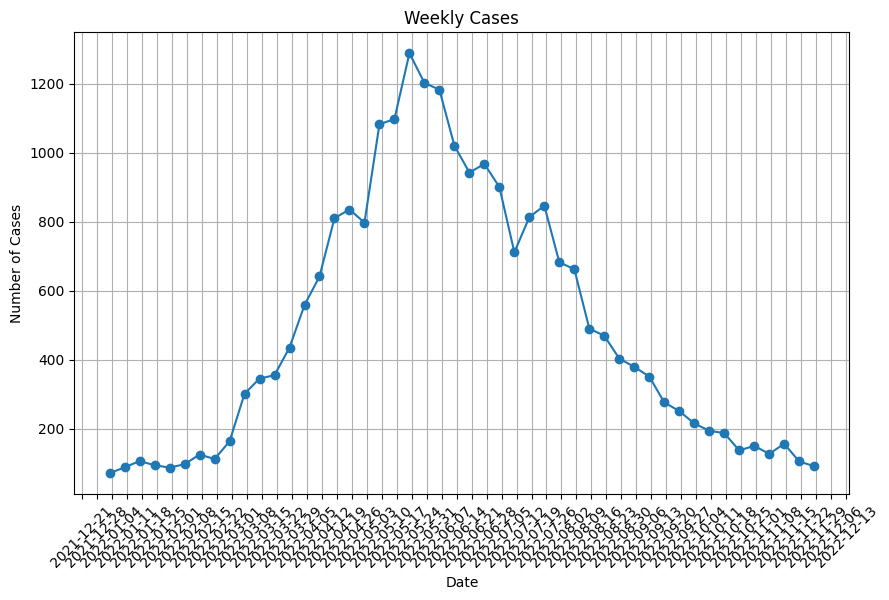

In [129]:
# Plot the data to visualize it
plt.figure(figsize=(10, 6))
plt.plot(weekly_cases['Date'], weekly_cases['cases'], marker='o', linestyle='-')
plt.title('Weekly Cases')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator())
plt.grid(True)
plt.show()

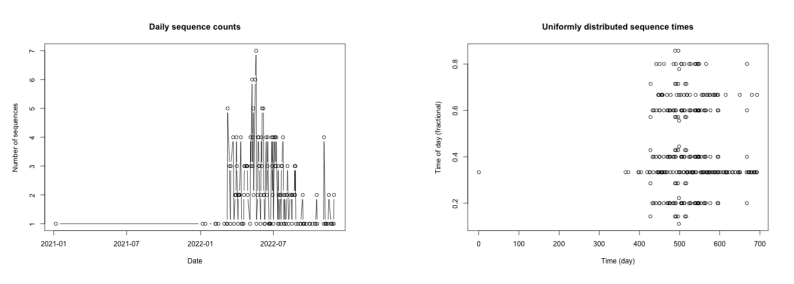

In [116]:
# Load the images
img1 = mpimg.imread(f'{project_folder}/timtam/sequence-dates.png')
img2 = mpimg.imread(f'{project_folder}/timtam/sequence-times.png')

# Create a figure and set the figure size
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axs[0].imshow(img1)
axs[0].axis('off')  # Hide axes

# Display the second image
axs[1].imshow(img2)
axs[1].axis('off')  # Hide axes

# Show the plot
plt.show()

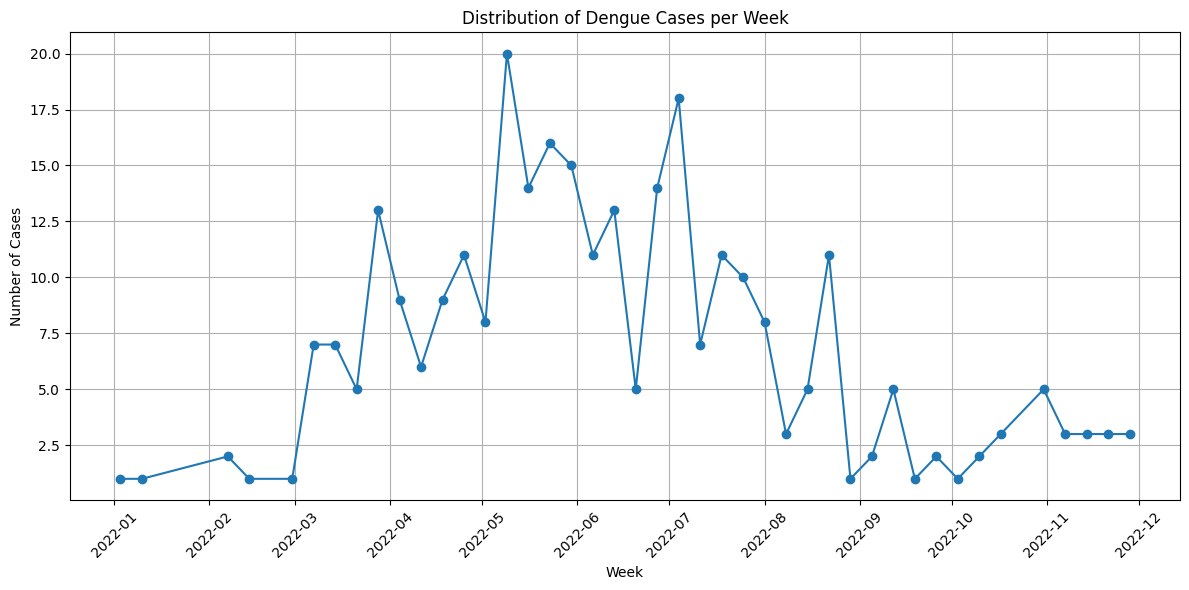

In [119]:
# Load the data
file_path = f'{project_folder}/dengue_samples.metadata.csv'
df = pd.read_csv(file_path, skiprows=[1])


# Convert the 'Receipt date (Diagnostics)' column to datetime format
df['Receipt date (Diagnostics)'] = pd.to_datetime(df['Receipt date (Diagnostics)'])

# Extract the week and year
df['YearWeek'] = df['Receipt date (Diagnostics)'].dt.to_period('W')

# Count the number of cases per week
weekly_cases = df['YearWeek'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_cases.index.to_timestamp(), weekly_cases.values, marker='o')
plt.title('Distribution of Dengue Cases per Week')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()